In [1]:
from astropy.io import fits
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/Users/viraj/winterdrp_offline')
from winterdrp_offline.utils import plot_image, write_image, get_table_from_ldac
from winterdrp_offline.image_operations import median_combine_images, normalize_and_median_combine_images
from winterdrp_offline.astrometry import get_astrometry_header_from_scamped_file
from winterdrp_offline.sextractor import run_sextractor
from winterdrp_offline.scamp import get_tmass_gaia_catalog_for_image
from winterdrp_offline.photcal import xmatch_img_ref_cats, calculate_zeropoint_outlier_rejection

In [2]:
base_dir = Path('/Users/viraj/winter_data/winter/hackathon_datasets')
name = 'ZTF25aadlqhw'
night = '20250220'
boardid = 4

target_dir = base_dir.joinpath(f'{name}/{night}/{boardid}/')

In [7]:
raw_list = glob(str(target_dir.joinpath('raw_unpacked/*fits')))
print(f"Found {len(raw_list)} raw files in {target_dir}")

Found 8 raw files in /Users/viraj/winter_data/winter/hackathon_datasets/ZTF25aadlqhw/20250220/4


<Axes: >

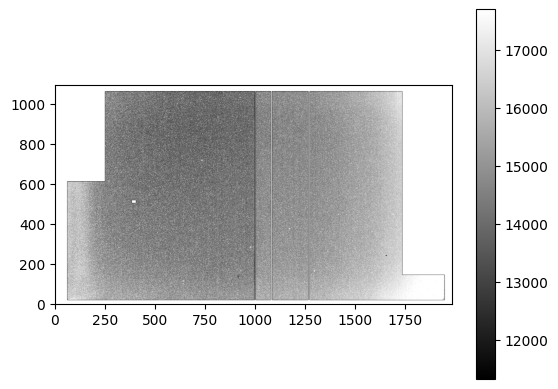

In [8]:
# Load a raw_unpacked file
raw_img = fits.getdata(raw_list[0])
plot_image(raw_img)

In [5]:
# Load the dark file
dark_list = glob(str(target_dir.joinpath('calibration_darks/*fits')))
dark_img = fits.getdata(dark_list[0]) * 120.0 # Note the dark frames are normalized


<Axes: >

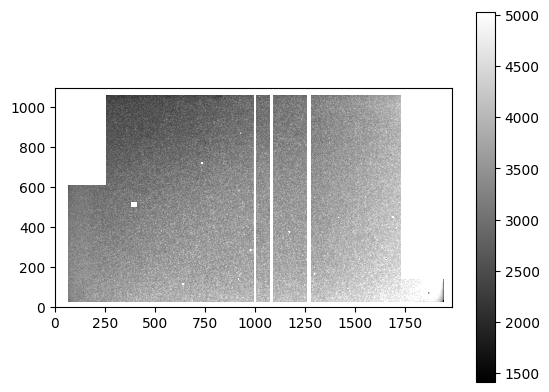

In [6]:
dark_calibrated_image = raw_img - dark_img
plot_image(dark_calibrated_image)

In [7]:
# Load a flat field
flat_list = glob(str(target_dir.joinpath('calibration_flats/*fits')))
flat_img = fits.getdata(flat_list[0])

<Axes: >

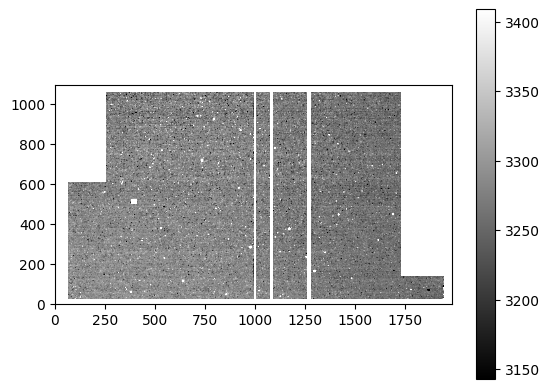

In [8]:
# Flat field the dark calibrated image
flat_calibrated_image = dark_calibrated_image / flat_img
plot_image(flat_calibrated_image)

/Users/viraj/winterdrp_offline/winterdrp_offline/image_operations.py:18: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(data_array, axis=0)


<Axes: >

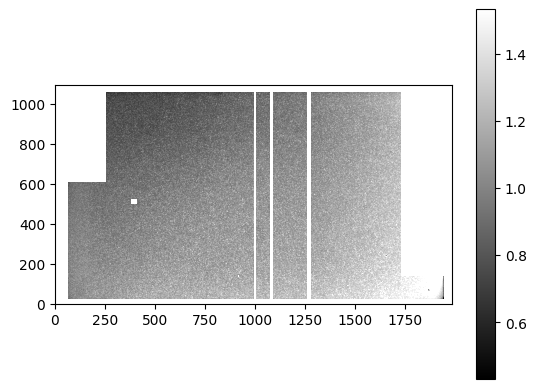

In [9]:
# Load all darkcal images and stack them to make a combined flat
darkcal_list = glob(str(target_dir.joinpath('darkcal/*fits')))
median_flat = median_combine_images(darkcal_list)
median_flat /= np.nanmedian(median_flat)
plot_image(median_flat)

/Users/viraj/winterdrp_offline/winterdrp_offline/image_operations.py:35: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(data_array, axis=0)


<Axes: >

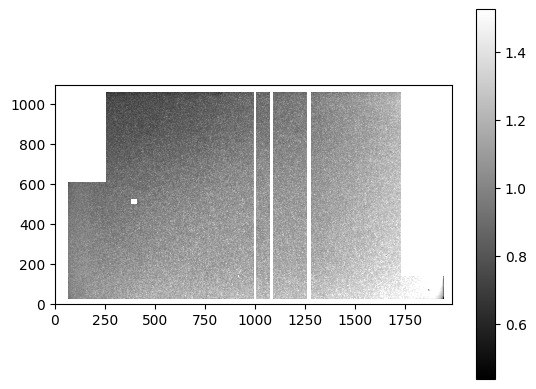

In [10]:
# Make flat by stacking normalized dark images
normalized_median_flat = normalize_and_median_combine_images(darkcal_list)
plot_image(normalized_median_flat)

<Axes: >

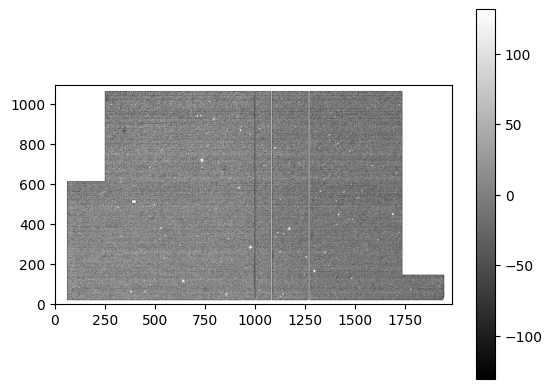

In [4]:
# Load a skysubtracted image
skysub_list = glob(str(target_dir.joinpath('skysub/*fits')))
skysub_img = fits.getdata(skysub_list[0])
plot_image(skysub_img)

In [5]:
# Assign an astrometry header from the post_scamp directory to this file and write it.
scamp_astrometry_header = get_astrometry_header_from_scamped_file(skysub_list[0])
skysub_scamped_filename = skysub_list[0].replace('skysub', 'skysub_scamped')
write_image(image=skysub_img, header=scamp_astrometry_header, filename=skysub_scamped_filename)

In [6]:
# Run sextractor on the skysubtracted image. With regions=True, a regions file
# with all detected sources is written in the target directory.
catname = run_sextractor(skysub_scamped_filename, weightimg=None, regions=True)

Executing command : sex -c /Users/viraj/winterdrp_offline/winterdrp_offline/config/astrom.sex /Users/viraj/winter_data/winter/hackathon_datasets/ZTF25aadlqhw/20250220/4/skysub_scamped/WINTERcamera_20250221-072926-636_mef_4_0_0.fits -CATALOG_NAME /Users/viraj/winter_data/winter/hackathon_datasets/ZTF25aadlqhw/20250220/4/skysub_scamped/WINTERcamera_20250221-072926-636_mef_4_0_0.fits.cat -CATALOG_TYPE FITS_LDAC -PARAMETERS_NAME /Users/viraj/winterdrp_offline/winterdrp_offline/config/astrom.param -FILTER_NAME /Users/viraj/winterdrp_offline/winterdrp_offline/config/default.conv -STARNNW_NAME /Users/viraj/winterdrp_offline/winterdrp_offline/config/default.nnw -PIXEL_SCALE 1.12 -DETECT_THRESH 3.0 -ANALYSIS_THRESH 3.0 -SATUR_LEVEL 60000.0 -WEIGHT_TYPE MAP_WEIGHT -WEIGHT_IMAGE /Users/viraj/winter_data/winter/hackathon_datasets/ZTF25aadlqhw/20250220/4/skysub_scamped/WINTERcamera_20250221-072926-636_mef_4_0_0_weight.fits -CHECKIMAGE_TYPE BACKGROUND,-BACKGROUND -CHECKIMAGE_NAME /Users/viraj/winter

In [26]:
image_catalog = get_table_from_ldac(catname)

In [27]:
#filter sources
image_catalog = image_catalog[(image_catalog['MAG_AUTO'] < 99) & (image_catalog['FLAGS']==0) & (image_catalog['FWHM_WORLD']<4.0/3600.0)]


In [28]:
print(f"Found {len(image_catalog)} good sources in the catalog")

Found 1794 good sources in the catalog


In [18]:
ref_cat = get_tmass_gaia_catalog_for_image(skysub_scamped_filename, write_catalog=True, write_regions=True)

SELECT * FROM gaiadr2.gaia_source AS g, gaiadr2.tmass_best_neighbour AS tbest, gaiadr1.tmass_original_valid AS tmass WHERE g.source_id = tbest.source_id AND tbest.tmass_oid = tmass.tmass_oid AND CONTAINS(POINT('ICRS', g.ra, g.dec), CIRCLE('ICRS', 224.8358, 51.5488, 0.2500))=1 AND tmass.j_m > 7.00 AND tmass.j_m < 20.00 AND tbest.number_of_mates=0 AND tbest.number_of_neighbours=1;
INFO: Query finished. [astroquery.utils.tap.core]
Yay


In [29]:
xmatch_cat, xmatch_ref_cat = xmatch_img_ref_cats(image_catalog, ref_cat, xmatch_radius_arcsec=2)
print(f"Found {len(xmatch_cat)} matched sources")

Found 67 matched sources


Text(0.5, 0, '2MASS J mag')

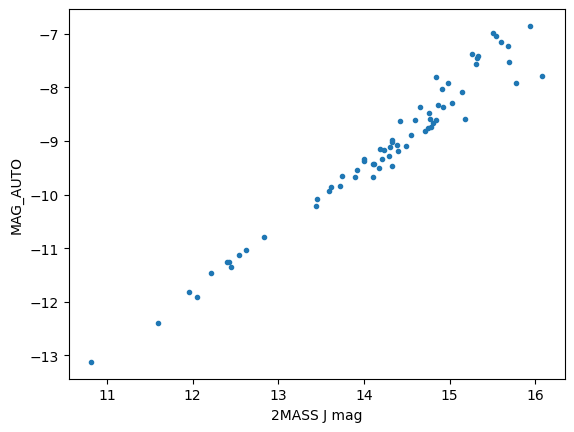

In [40]:
plt.plot(xmatch_ref_cat['j_m'], xmatch_cat['MAG_AUTO'], '.')
plt.ylabel('MAG_AUTO')
plt.xlabel('2MASS J mag')

In [46]:
zp, zpstd, nstars = calculate_zeropoint_outlier_rejection(xmatch_cat['MAG_AUTO'], xmatch_ref_cat['j_m'], outlier_rejection_thresholds=[1.5])

Text(0.5, 0, '2MASS J mag')

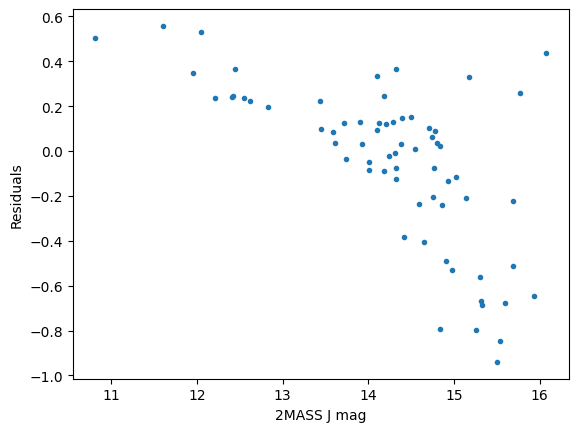

In [45]:
residuals = xmatch_ref_cat['j_m'] - xmatch_cat['MAG_AUTO'] - zp
plt.plot(xmatch_ref_cat['j_m'], residuals, '.')
plt.ylabel('Residuals')
plt.xlabel('2MASS J mag')

In [ ]:
# Our goal is to improve this plot.